# Import packages & functions

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm.auto import tqdm
import webdataset as wds
import gc

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator
from versatile_diffusion import Reconstructor

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

/admin/home-ckadirt/mei-env/lib/python3.11/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.0+cu121 with CUDA 1201 (you have 2.4.1+cu121)
    Python  3.11.6 (you have 3.11.10)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
/admin/home-ckadirt/mei-env/lib/python3.11/site-packages/xformers/triton/softmax.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16 if _triton_softmax_fp16_enabled else None)
/a

In [2]:
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

data_type = torch.float16 # change depending on your mixed_precision
num_devices = torch.cuda.device_count()
if num_devices==0: num_devices = 1

# First use "accelerate config" in terminal and setup using deepspeed stage 2 with CPU offloading!
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
if utils.is_interactive(): # set batch size here if using interactive notebook instead of submitting job
    global_batch_size = batch_size = 32
else:
    global_batch_size = os.environ["GLOBAL_BATCH_SIZE"]
    batch_size = int(os.environ["GLOBAL_BATCH_SIZE"]) // num_devices

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

LOCAL RANK  0


In [3]:
print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)
print = accelerator.print # only print if local_rank=0

PID of this process = 3499763
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1 data_type = torch.float16


# Configurations

In [4]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "testing_txt_combined"
    print("model_name:", model_name)
    
    # global_batch_size and batch_size should already be defined in the 2nd cell block
    jupyter_args = f"--data_path=/weka/proj-medarc/shared/mindeyev2_dataset \
                    --cache_dir=/weka/proj-medarc/shared/cache \
                    --model_name={model_name} \
                    --no-multi_subject --subj=1 --batch_size={batch_size} --num_sessions=40 \
                    --hidden_dim=1024 --clip_scale=1. \
                    --blurry_recon --blur_scale=.5  \
                    --seq_past=0 --seq_future=0 \
                    --use_prior --prior_scale=30 \
                    --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=150 --no-use_image_aug \
                    --ckpt_interval=1 --ckpt_saving --dual_guidance"

    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: testing_txt_combined
--data_path=/weka/proj-medarc/shared/mindeyev2_dataset                     --cache_dir=/weka/proj-medarc/shared/cache                     --model_name=testing_txt_combined                     --no-multi_subject --subj=1 --batch_size=32 --num_sessions=40                     --hidden_dim=1024 --clip_scale=1.                     --blurry_recon --blur_scale=.5                      --seq_past=0 --seq_future=0                     --use_prior --prior_scale=30                     --n_blocks=4 --max_lr=3e-4 --mixup_pct=.33 --num_epochs=150 --no-use_image_aug                     --ckpt_interval=1 --ckpt_saving --dual_guidance


In [5]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--subj",type=int, default=1, choices=[1,2,3,4,5,6,7,8,9,10,11],
    help="Validate on which subject?",
)
parser.add_argument(
    "--multisubject_ckpt", type=str, default=None,
    help="Path to pre-trained multisubject model to finetune a single subject from. multisubject must be False.",
)
parser.add_argument(
    "--num_sessions", type=int, default=1,
    help="Number of training sessions to include",
)
parser.add_argument(
    "--use_prior",action=argparse.BooleanOptionalAction,default=True,
    help="whether to train diffusion prior (True) or just rely on retrieval part of the pipeline (False)",
)
parser.add_argument(
    "--visualize_prior",action=argparse.BooleanOptionalAction,default=False,
    help="output visualizations from unCLIP every ckpt_interval (requires much more memory!)",
)
parser.add_argument(
    "--batch_size", type=int, default=16,
    help="Batch size can be increased by 10x if only training retreival submodule and not diffusion prior",
)
parser.add_argument(
    "--wandb_log",action=argparse.BooleanOptionalAction,default=False,
    help="whether to log to wandb",
)
parser.add_argument(
    "--resume_from_ckpt",action=argparse.BooleanOptionalAction,default=False,
    help="if not using wandb and want to resume from a ckpt",
)
parser.add_argument(
    "--wandb_project",type=str,default="stability",
    help="wandb project name",
)
parser.add_argument(
    "--mixup_pct",type=float,default=.33,
    help="proportion of way through training when to switch from BiMixCo to SoftCLIP",
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
    help="whether to output blurry reconstructions",
)
parser.add_argument(
    "--blur_scale",type=float,default=.5,
    help="multiply loss from blurry recons by this number",
)
parser.add_argument(
    "--clip_scale",type=float,default=1.,
    help="multiply contrastive loss by this number",
)
parser.add_argument(
    "--prior_scale",type=float,default=30,
    help="multiply diffusion prior loss by this",
)
parser.add_argument(
    "--use_image_aug",action=argparse.BooleanOptionalAction,default=False,
    help="whether to use image augmentation",
)
parser.add_argument(
    "--num_epochs",type=int,default=150,
    help="number of epochs of training",
)
parser.add_argument(
    "--multi_subject",action=argparse.BooleanOptionalAction,default=False,
)
parser.add_argument(
    "--new_test",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--n_blocks",type=int,default=4,
)
parser.add_argument(
    "--hidden_dim",type=int,default=1024,
)
parser.add_argument(
    "--seq_past",type=int,default=0,
)
parser.add_argument(
    "--seq_future",type=int,default=0,
)
parser.add_argument(
    "--lr_scheduler_type",type=str,default='cycle',choices=['cycle','linear'],
)
parser.add_argument(
    "--ckpt_saving",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--ckpt_interval",type=int,default=5,
    help="save backup ckpt and reconstruct every x epochs",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--max_lr",type=float,default=3e-4,
)
parser.add_argument(
    "--train_imageryrf",action=argparse.BooleanOptionalAction,default=False,
    help="Use the ImageryRF dataset for pretraining",
)
parser.add_argument(
    "--no_nsd",action=argparse.BooleanOptionalAction,default=False,
    help="Don't use the Natural Scenes Dataset for pretraining",
)
parser.add_argument(
    "--snr_threshold",type=float,default=-1.0,
    help="Used for calculating SNR on a whole brain to narrow down voxels.",
)
parser.add_argument(
    "--weight_decay",type=float,default=1e-2,
)
parser.add_argument(
    "--mode",type=str,default="all",
)
parser.add_argument(
    "--dual_guidance",action=argparse.BooleanOptionalAction,default=False,
    help="Use the decoded captions for dual guidance",
)


if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)
    
# seed all random functions
utils.seed_everything(seed)

outdir = os.path.abspath(f'../train_logs/{model_name}')
if not os.path.exists(outdir) and ckpt_saving:
    os.makedirs(outdir,exist_ok=True)
    
if use_image_aug or blurry_recon:
    import kornia
    from kornia.augmentation.container import AugmentationSequential
if use_image_aug:
    img_augment = AugmentationSequential(
        kornia.augmentation.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1, p=0.3),
        same_on_batch=False,
        data_keys=["input"],
    )
    
if multi_subject:
    if train_imageryrf:
            # 9,10,11 is ImageryRF subjects
        if no_nsd:
            subj_list = np.arange(9,12)
        else:
            subj_list = np.arange(1,12)
    else:
        subj_list = np.arange(1,9)
    subj_list = subj_list[subj_list != subj]
else:
    subj_list = [subj]

print("subj_list", subj_list, "num_sessions", num_sessions)

subj_list [1] num_sessions 40


# Prep data, models, and dataloaders

### Creating wds dataloader, preload betas and all 73k possible images

In [6]:
def my_split_by_node(urls): return urls
num_voxels_list = []

if multi_subject:
    nsessions_allsubj=np.array([40, 40, 32, 30, 40, 32, 40, 30])
    num_samples_per_epoch = (750*40) // num_devices 
else:
    num_samples_per_epoch = (750*num_sessions) // num_devices 

print("dividing batch size by subj_list, which will then be concatenated across subj during training...") 
batch_size = batch_size // len(subj_list)

num_iterations_per_epoch = num_samples_per_epoch // (batch_size*len(subj_list))

print("batch_size =", batch_size, "num_iterations_per_epoch =",num_iterations_per_epoch, "num_samples_per_epoch =",num_samples_per_epoch)



dividing batch size by subj_list, which will then be concatenated across subj during training...
batch_size = 32 num_iterations_per_epoch = 937 num_samples_per_epoch = 30000


In [7]:
train_data = {}
train_dl = {}
num_voxels = {}
voxels = {}
for s in subj_list:
    print(f"Training with {num_sessions} sessions")
    # If an NSD subject
    if s < 9:
        if multi_subject:
            train_url = f"{data_path}/wds/subj{s:02d}/train/" + "{0.." + f"{nsessions_allsubj[s-1]-1}" + "}.tar"
        else:
            train_url = f"{data_path}/wds/subj{s:02d}/train/" + "{0.." + f"{num_sessions-1}" + "}.tar"
        print(train_url)
        
        train_data[f'subj{s:02d}'] = wds.WebDataset(train_url,resampled=True,nodesplitter=my_split_by_node)\
                            .shuffle(750, initial=1500, rng=random.Random(42))\
                            .decode("torch")\
                            .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                            .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
        train_dl[f'subj{s:02d}'] = torch.utils.data.DataLoader(train_data[f'subj{s:02d}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)

        betas = utils.create_snr_betas(subject=s, data_type=data_type, data_path=data_path, threshold = snr_threshold)
        print(betas.shape)
        num_voxels_list.append(betas[0].shape[-1])
        num_voxels[f'subj{s:02d}'] = betas[0].shape[-1]
        voxels[f'subj{s:02d}'] = betas
    elif s < 12:
        train_url = ""
        test_url = ""
        betas, images, _, _ = utils.load_imageryrf(subject=int(s-8), mode=mode, mask=True, stimtype="object", average=False, nest=False, split=True)
        betas = torch.where(torch.isnan(betas), torch.zeros_like(betas), betas)
        betas = betas.to("cpu").to(data_type)
        num_voxels_list.append(betas[0].shape[-1])
        num_voxels[f'subj{s:02d}'] = betas[0].shape[-1]
        num_nan_values = torch.sum(torch.isnan(betas))
        print("Number of NaN values in betas:", num_nan_values.item())
        indices = torch.randperm(len(betas))
        shuffled_betas = betas[indices]
        shuffled_images = images[indices]
        train_data[f'subj{s:02d}'] = torch.utils.data.TensorDataset(shuffled_betas, shuffled_images)
        train_dl[f'subj{s:02d}'] = torch.utils.data.DataLoader(train_data[f'subj{s:02d}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
        
        
    # elif s < 15:
    #     betas, images = utils.load_imageryrf(subject=int(s-11), mode="imagery", mask=True, stimtype="object", average=False, nest=False)
    #     betas = torch.where(torch.isnan(betas), torch.zeros_like(betas), betas)
    #     betas = betas.to("cpu").to(data_type)
    #     num_voxels_list.append(betas[0].shape[-1])
    #     num_voxels[f'subj{s:02d}'] = betas[0].shape[-1]
        
    #     indices = torch.randperm(len(betas))
    #     shuffled_betas = betas[indices]
    #     shuffled_images = images[indices]
    #     train_data[f'subj{s:02d}'] = torch.utils.data.TensorDataset(shuffled_betas, shuffled_images)
    #     train_dl[f'subj{s:02d}'] = torch.utils.data.DataLoader(train_data[f'subj{s:02d}'], batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True)
    print(f"num_voxels for subj{s:02d}: {num_voxels[f'subj{s:02d}']}")

print("Loaded all subj train dls and betas!\n")

# Validate only on one subject (doesn't support ImageryRF)
if multi_subject: 
    subj = subj_list[0] # cant validate on the actual held out person so picking first in subj_list
if not new_test: # using old test set from before full dataset released (used in original MindEye paper)
    if subj==3:
        num_test=2113
    elif subj==4:
        num_test=1985
    elif subj==6:
        num_test=2113
    elif subj==8:
        num_test=1985
    else:
        num_test=2770
    test_url = f"{data_path}/wds/subj0{subj}/test/" + "0.tar"
elif new_test: # using larger test set from after full dataset released
    if subj==3:
        num_test=2371
    elif subj==4:
        num_test=2188
    elif subj==6:
        num_test=2371
    elif subj==8:
        num_test=2188
    else:
        num_test=3000
    test_url = f"{data_path}/wds/subj0{subj}/new_test/" + "0.tar"
print(test_url)
if subj < 9:
    test_data = wds.WebDataset(test_url,resampled=False,nodesplitter=my_split_by_node)\
                        .shuffle(750, initial=1500, rng=random.Random(42))\
                        .decode("torch")\
                        .rename(behav="behav.npy", past_behav="past_behav.npy", future_behav="future_behav.npy", olds_behav="olds_behav.npy")\
                        .to_tuple(*["behav", "past_behav", "future_behav", "olds_behav"])
    test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
else:
    _, _, betas, images = utils.load_imageryrf(subject=int(subj-8), mode=mode, mask=True, stimtype="object", average=False, nest=True, split=True)
    num_test = len(betas)
    betas = torch.where(torch.isnan(betas), torch.zeros_like(betas), betas)
    betas = betas.to("cpu").to(data_type)
    num_nan_values = torch.sum(torch.isnan(betas))
    print("Number of NaN values in test betas:", num_nan_values.item())
    test_data = torch.utils.data.TensorDataset(betas, images)
    test_dl = torch.utils.data.DataLoader(test_data, batch_size=num_test, shuffle=False, drop_last=True, pin_memory=True)
print(f"Loaded test dl for subj{subj}!\n")

seq_len = seq_past + 1 + seq_future
print(f"currently using {seq_len} seq_len (chose {seq_past} past behav and {seq_future} future behav)")

Training with 40 sessions
/weka/proj-medarc/shared/mindeyev2_dataset/wds/subj01/train/{0..39}.tar


/admin/home-ckadirt/mei-env/lib/python3.11/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


torch.Size([30000, 15724])
num_voxels for subj01: 15724
Loaded all subj train dls and betas!

/weka/proj-medarc/shared/mindeyev2_dataset/wds/subj01/new_test/0.tar
Loaded test dl for subj1!

currently using 1 seq_len (chose 0 past behav and 0 future behav)


In [8]:
# Load 73k NSD images
f = h5py.File(f'{data_path}/coco_images_224_float16.hdf5', 'r')
images = f['images'] # if you go OOM you can remove the [:] so it isnt preloaded to cpu! (will require a few edits elsewhere tho)
# images = torch.Tensor(images).to("cpu").to(data_type)
print("Loaded all 73k possible NSD images to cpu!", images.shape)
# Load 73k NSD captions
# captions = np.load(f'{data_path}/preprocessed_data/annots_73k.npy')
captions = np.load(f'{data_path}/annots_73k.npy')
print("Loaded all 73k NSD captions to cpu!", captions.shape)

Loaded all 73k possible NSD images to cpu! (73000, 3, 224, 224)
Loaded all 73k NSD captions to cpu! (73000,)


## Load models

### CLIP image embeddings  model

In [9]:
clip_emb_dim = 768
clip_seq_dim = 257
clip_text_seq_dim=77
clip_extractor = Reconstructor(device=device, cache_dir=f'{cache_dir}/versatile_diffusion_ckpts')


Reconstructor: Loading model... fp16: True
Taking new code 2.

#######################
# Running in eps mode #
#######################

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


/admin/home-ckadirt/mei-env/lib/python3.11/site-packages/versatile_diffusion/lib/model_zoo/common/get_model.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.l

Load pth from /weka/proj-medarc/shared/cache/versatile_diffusion_ckpts/kl-f8.pth
Load autoencoderkl with total 83653863 parameters,72921.759 parameter sum.
Load optimus_bert_connector with total 109489920 parameters,18987.612 parameter sum.
Load optimus_gpt2_connector with total 132109824 parameters,19048.214 parameter sum.
Load pth from /weka/proj-medarc/shared/cache/versatile_diffusion_ckpts/optimus-vae.pth
Load optimus_vae_next with total 241599744 parameters,-344611.688 parameter sum.
Load clip_image_context_encoder with total 427616513 parameters,64007.510 parameter sum.
Load clip_text_context_encoder with total 427616513 parameters,64007.510 parameter sum.
Load openai_unet_2d_next with total 859520964 parameters,100311.691 parameter sum.
Load openai_unet_0d_next with total 1706797888 parameters,249763.249 parameter sum.
Load vd_v2_0 with total 3746805485 parameters,206400.030 parameter sum.


/admin/home-ckadirt/mei-env/lib/python3.11/site-packages/versatile_diffusion/reconstructor.py:124: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(f'{cache_dir

### SD VAE

In [10]:
if blurry_recon:
    from diffusers import AutoencoderKL    
    autoenc = AutoencoderKL(
        down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
        up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
        block_out_channels=[128, 256, 512, 512],
        layers_per_block=2,
        sample_size=256,
    )
    ckpt = torch.load(f'{cache_dir}/sd_image_var_autoenc.pth')
    autoenc.load_state_dict(ckpt)
    
    autoenc.eval()
    autoenc.requires_grad_(False)
    autoenc.to(device)
    utils.count_params(autoenc)

/admin/home-ckadirt/mei-env/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


param counts:
83,653,863 total
0 trainable


/tmp/ipykernel_3499763/1579577105.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(f'{cache_dir}/sd_image_var_autoenc.pth')


### MindEye modules

In [11]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x
        
model = MindEyeModule()
model

MindEyeModule()

In [12]:
class RidgeRegression(nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
        
model.ridge = RidgeRegression(num_voxels_list, out_features=hidden_dim, seq_len=seq_len)
utils.count_params(model.ridge)
utils.count_params(model)

# test on subject 1 with fake data
b = torch.randn((2,seq_len,num_voxels_list[0]))
print(b.shape, model.ridge(b,0).shape)

param counts:
16,102,400 total
16,102,400 trainable
param counts:
16,102,400 total
16,102,400 trainable
torch.Size([2, 1, 15724]) torch.Size([2, 1, 1024])


In [13]:
from models import BrainNetwork
model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, n_blocks=n_blocks,
                          clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim, 
                          blurry_recon=blurry_recon, clip_scale=clip_scale, text_clip=dual_guidance)
utils.count_params(model.backbone)
utils.count_params(model)

# test that the model works on some fake data
b = torch.randn((2,seq_len,hidden_dim))
print("b.shape",b.shape)

backbone_,backbone_txt_, clip_, blur_ = model.backbone(b)
print(backbone_.shape, backbone_txt_.shape, clip_.shape, blur_[0].shape, blur_[1].shape)

param counts:
280,407,420 total
280,407,420 trainable
param counts:
296,509,820 total
296,509,820 trainable
b.shape torch.Size([2, 1, 1024])
torch.Size([2, 257, 768]) torch.Size([2, 77, 768]) torch.Size([2, 257, 768]) torch.Size([2, 4, 28, 28]) torch.Size([2, 49, 512])


### Adding diffusion prior if use_prior=True

In [14]:
if use_prior:
    from models import *

    # setup diffusion prior network
    out_dim = clip_emb_dim
    depth = 6
    dim_head = 64
    heads = clip_emb_dim//64 # heads * dim_head = clip_emb_dim
    timesteps = 100

    prior_network = PriorNetwork(
            dim=out_dim,
            depth=depth,
            dim_head=dim_head,
            heads=heads,
            causal=False,
            num_tokens = clip_seq_dim,
            learned_query_mode="pos_emb"
        )
    model.diffusion_prior = BrainDiffusionPrior(
        net=prior_network,
        image_embed_dim=out_dim,
        condition_on_text_encodings=False,
        timesteps=timesteps,
        cond_drop_prob=0.2,
        image_embed_scale=None,
    )
    if dual_guidance:
        prior_network_txt = PriorNetwork(
                dim=out_dim,
                depth=depth,
                dim_head=dim_head,
                heads=heads,
                causal=False,
                num_tokens = clip_text_seq_dim,
                learned_query_mode="pos_emb"
            )
    

        model.diffusion_prior_txt = BrainDiffusionPrior(
            net=prior_network_txt,
            image_embed_dim=out_dim,
            condition_on_text_encodings=False,
            timesteps=timesteps,
            cond_drop_prob=0.2,
            image_embed_scale=None,
        )
        utils.count_params(model.diffusion_prior_txt)
    utils.count_params(model.diffusion_prior)
    utils.count_params(model)
    


param counts:
55,640,464 total
55,640,448 trainable
param counts:
56,055,184 total
56,055,168 trainable
param counts:
408,205,468 total
408,205,436 trainable


### Setup optimizer / lr / ckpt saving

In [15]:
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

opt_grouped_parameters = [
    {'params': [p for n, p in model.ridge.named_parameters()], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.backbone.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.backbone.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]
if use_prior:
    opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.diffusion_prior.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ])
    if dual_guidance:
        opt_grouped_parameters.extend([
        {'params': [p for n, p in model.diffusion_prior_txt.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
        {'params': [p for n, p in model.diffusion_prior_txt.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ])
        

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=max_lr)

if lr_scheduler_type == 'linear':
    lr_scheduler = torch.optim.lr_scheduler.LinearLR(
        optimizer,
        total_iters=int(np.floor(num_epochs*num_iterations_per_epoch)),
        last_epoch=-1
    )
elif lr_scheduler_type == 'cycle':
    total_steps=int(np.floor(num_epochs*num_iterations_per_epoch))
    print("total_steps", total_steps)
    lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=max_lr,
        total_steps=total_steps,
        final_div_factor=1000,
        last_epoch=-1, pct_start=2/num_epochs
    )
    
def save_ckpt(tag):
    ckpt_path = outdir+f'/{tag}.pth'
    if accelerator.is_main_process:
        unwrapped_model = model
        torch.save({
            'epoch': epoch,
            'model_state_dict': unwrapped_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'train_losses': losses,
            'test_losses': test_losses,
            'lrs': lrs,
            }, ckpt_path)
    print(f"\n---saved {outdir}/{tag} ckpt!---\n")

def load_ckpt(tag,load_lr=True,load_optimizer=True,load_epoch=True,strict=True,outdir=outdir,multisubj_loading=False): 
    print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
    checkpoint = torch.load(f'{outdir}/{tag}.pth', map_location='cpu')
    state_dict = checkpoint['model_state_dict']
    if multisubj_loading: # remove incompatible ridge layer that will otherwise error
        state_dict.pop('ridge.linears.0.weight',None)
    model.load_state_dict(state_dict, strict=strict)
    if load_epoch:
        globals()["epoch"] = checkpoint['epoch']
        print("Epoch",epoch)
    if load_optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if load_lr:
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    del checkpoint

print("\nDone with model preparations!")
num_params = utils.count_params(model)

total_steps 140550

Done with model preparations!
param counts:
408,205,468 total
408,205,436 trainable


# Weights and Biases

In [16]:
if local_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'mindeye2'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "num_sessions": num_sessions,
      "num_params": num_params,
      "clip_scale": clip_scale,
      "prior_scale": prior_scale,
      "blur_scale": blur_scale,
      "use_image_aug": use_image_aug,
      "max_lr": max_lr,
      "mixup_pct": mixup_pct,
      "num_samples_per_epoch": num_samples_per_epoch,
      "num_test": num_test,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "seed": seed,
      "distributed": distributed,
      "num_devices": num_devices,
      "world_size": world_size,
      "train_url": train_url,
      "test_url": test_url,
      "train_imageryrf": train_imageryrf,
      "mode": mode,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        name=model_name,
        config=wandb_config,
        resume=None,
    )
else:
    wandb_log = False

# Main

In [17]:
epoch = 0
losses, test_losses, lrs = [], [], []
best_test_loss = 1e9
torch.cuda.empty_cache()

In [18]:
# load multisubject stage1 ckpt if set
if multisubject_ckpt is not None and not resume_from_ckpt:
    load_ckpt("last",outdir=multisubject_ckpt,load_lr=False,load_optimizer=False,load_epoch=False,strict=False,multisubj_loading=True)

In [19]:
# load saved ckpt model weights into current model
if resume_from_ckpt:
    load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)
# elif wandb_log:
#     if wandb.run.resumed:
#         load_ckpt("last",load_lr=True,load_optimizer=True,load_epoch=True)

In [20]:
train_dls = [train_dl[f'subj{s:02d}'] for s in subj_list]

model, optimizer, *train_dls, lr_scheduler = accelerator.prepare(model, optimizer, *train_dls, lr_scheduler)
# leaving out test_dl since we will only have local_rank 0 device do evals

testing_txt_combined starting with epoch 0 / 150


  0%|                                                                                                         …

/tmp/ipykernel_3499763/1951086255.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=data_type):
/tmp/ipykernel_3499763/1951086255.py:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=data_type):
/tmp/ipykernel_3499763/1951086255.py:255: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type):


---


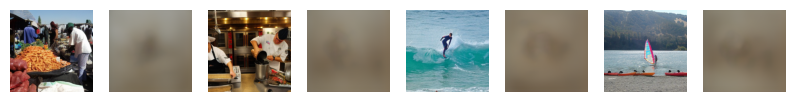


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


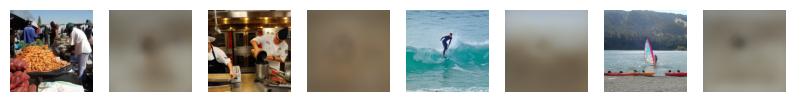


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


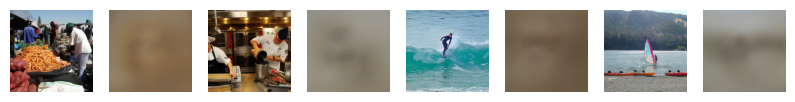


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


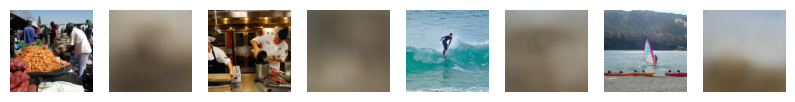


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


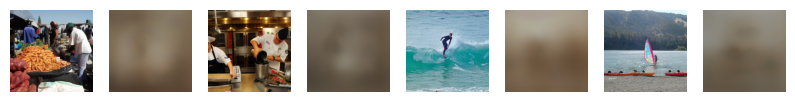


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


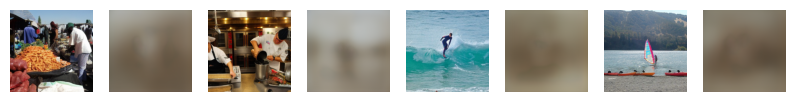


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


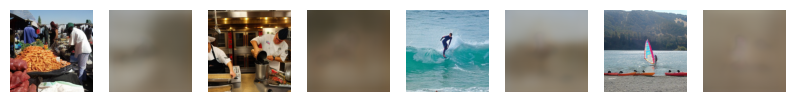


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


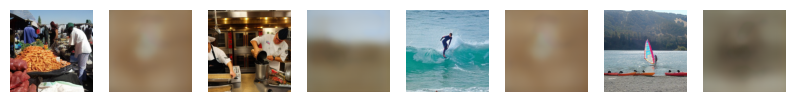


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


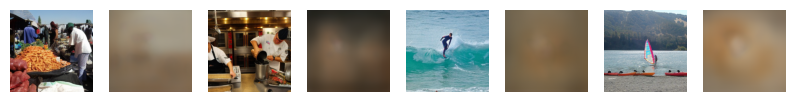


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


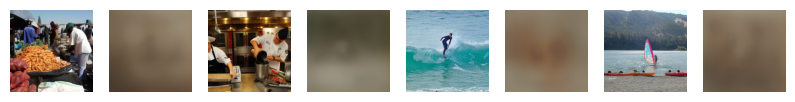


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


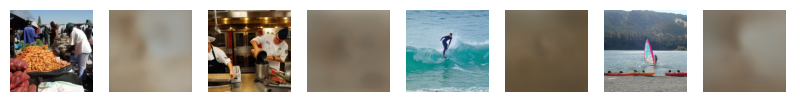


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


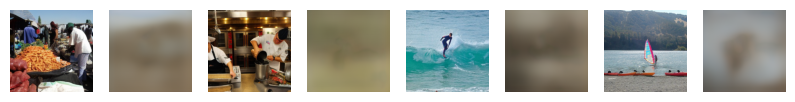


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


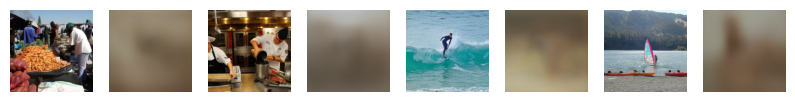


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


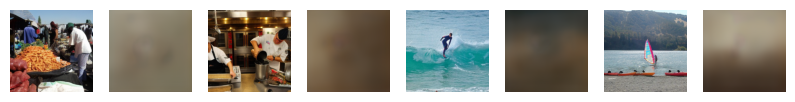


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


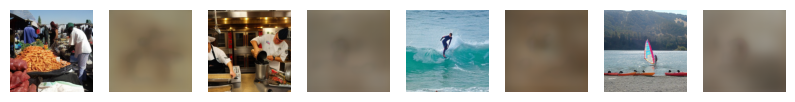


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


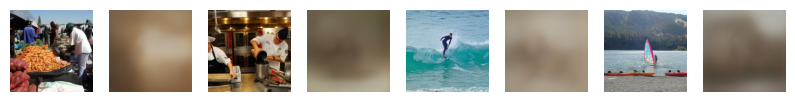


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


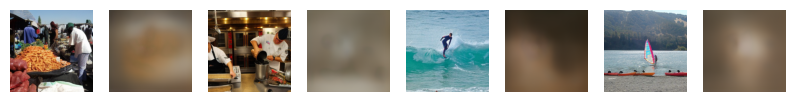


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


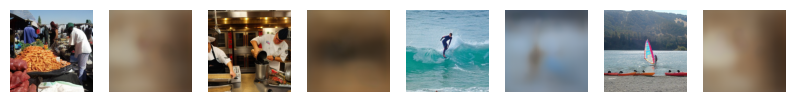


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


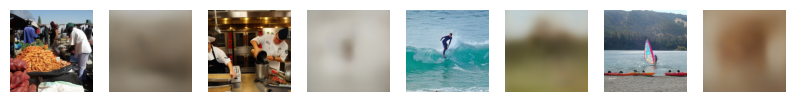


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---

---


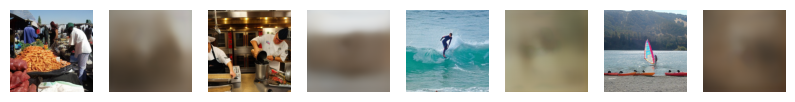


---saved /weka/proj-fmri/ckadirt/imagery_clean/MindEye_Imagery/train_logs/testing_txt_combined/last ckpt!---



In [ ]:
from tqdm.auto import tqdm
print(f"{model_name} starting with epoch {epoch} / {num_epochs}")
progress_bar = tqdm(range(epoch,num_epochs), ncols=1200, disable=(local_rank!=0))
test_image, test_voxel = None, None
test_caption = []
mse = nn.MSELoss()
l1 = nn.L1Loss()
soft_loss_temps = utils.cosine_anneal(0.004, 0.0075, num_epochs - int(mixup_pct * num_epochs))

for epoch in progress_bar:
    model.train()

    fwd_percent_correct = 0.
    bwd_percent_correct = 0.
    test_fwd_percent_correct = 0.
    test_bwd_percent_correct = 0.
    
    recon_cossim = 0.
    recon_cossim_txt = 0.
    test_recon_cossim = 0.
    test_recon_cossim_txt = 0.
    recon_mse = 0.
    test_recon_mse = 0.

    loss_clip_total = 0.
    loss_blurry_total = 0.
    loss_blurry_cont_total = 0.
    test_loss_clip_total = 0.
    
    loss_prior_total = 0.
    loss_prior_total_txt = 0.
    test_loss_prior_total = 0.
    test_loss_prior_total_txt = 0.

    blurry_pixcorr = 0.
    test_blurry_pixcorr = 0. # needs >.456 to beat low-level subj01 results in mindeye v1

    # pre-load all batches for this epoch (it's MUCH faster to pre-load in bulk than to separate loading per batch)
    voxel_iters = {} # empty dict because diff subjects have differing # of voxels
    image_iters = torch.zeros(num_iterations_per_epoch, batch_size*len(subj_list), 3, 224, 224).float()
    caption_iters = {}
    perm_iters, betas_iters, select_iters = {}, {}, {}
    # print(f"num_iterations_per_epoch: {num_iterations_per_epoch}, batch_size: {batch_size}, len(subj_list): {len(subj_list)}")
    for s, (cur_subj, train_dl) in enumerate(zip(subj_list, train_dls)):
        with torch.cuda.amp.autocast(dtype=data_type):
            i = 0
            while i < num_iterations_per_epoch:
                # print(f"restarting data loader at i={i} for s={s}")
                for data in train_dl:  
                    if cur_subj < 9:
                        behav0, past_behav0, future_behav0, old_behav0 = data
                        
                        # image0 = images[behav0[:,0,0].cpu().long()].float()
                        # image_sorted_idx = behav0[:,0,0].cpu().long().numpy()
                        # image_sorted_idx = np.unique(np.sort(image_sorted_idx))
                        
                        # image0 = images[image_sorted_idx]
                        # image0 = torch.tensor(image0, dtype=torch.float16, device="cpu")  # Convert to tensor
                        # while image0.shape[0] < batch_size:
                        #     image0 = torch.cat((image0, image0[0].unsqueeze(0)), dim=0)
                        image_idx = behav0[:,0,0].cpu().long().numpy()
                        local_idx, image_sorted_idx = np.unique(image_idx, return_index=True)                
                        # if len(image0) != len(image_idx): # hdf5 cant handle duplicate indexing
                        #     continue
                        image0 = torch.tensor(images[local_idx], dtype=data_type)
                        image_iters[i, s*batch_size:s*batch_size+image0.shape[0]] = image0
                        caption0 = captions[local_idx]
                        caption_iters[f"subj{subj_list[s]:02d}_iter{i}"] = caption0
                        # print(caption0.shape)
                        # for caption in caption0:
                        #     caption_iters.append(caption)
                        
                        # voxel_sorted_idx = behav0[:,0,5].cpu().long().numpy()
                        # voxel_sorted_idx = np.unique(np.sort(voxel_sorted_idx))
                        # voxel0 = voxels[f'subj{subj_list[s]:02d}'][voxel_sorted_idx]
                        # voxel0 = torch.Tensor(voxel0)
                        # while voxel0.shape[0] < batch_size:
                        #     voxel0 = torch.cat((voxel0, voxel0[0].unsqueeze(0)), dim=0)
                        voxel_idx = behav0[:,0,5].cpu().long().numpy()
                        voxel_sorted_idx = voxel_idx[image_sorted_idx]
                        voxel0 = voxels[f'subj0{subj_list[s]}'][voxel_sorted_idx]
                        voxel0 = torch.Tensor(voxel0)#.unsqueeze(1)
                    else:
                        voxel0, image0 = data
                        image0 = torch.nn.functional.interpolate(image0, size=(224, 224), mode='bilinear', align_corners=False)
                        image_iters[i,s*batch_size:s*batch_size+batch_size] = image0
                    
                    if seq_len==1:
                        voxel0 = voxel0.unsqueeze(1)
                    else:
                        if seq_past>0:
                            past_behavior = past_behav0[:,:(seq_past),5].cpu().long()
                            past_voxel0 = voxels[f'subj{subj_list[s]:02d}'][past_behavior]
                            past_voxel0[past_behavior==-1] = voxel0[torch.where(past_behavior==-1)[0]] # replace invalid past voxels 
                            past_voxel0 = torch.Tensor(past_voxel0)

                            # if shared1000, then you need to mask it out 
                            for p in range(seq_past):
                                mask = (past_behav0[:,p,-1] == 1) # [16,] bool
                                index = torch.nonzero(mask.cpu()).squeeze()
                                past_voxel0[index,p,:] = torch.zeros_like(past_voxel0[index,p,:])

                        if seq_future>0:
                            future_behavior = future_behav0[:,:(seq_future),5].cpu().long()
                            future_voxel0 = voxels[f'subj{subj_list[s]:02d}'][future_behavior]
                            future_voxel0[future_behavior==-1] = voxel0[torch.where(future_behavior==-1)[0]] # replace invalid past voxels 
                            future_voxel0 = torch.Tensor(future_voxel0)

                            # if shared1000, then you need to mask it out 
                            for p in range(seq_future):
                                mask = (future_behav0[:,p,-1] == 1) # [16,] bool
                                index = torch.nonzero(mask.cpu()).squeeze()
                                future_voxel0[index,p,:] = torch.zeros_like(future_voxel0[index,p,:])

                        # concatenate current timepoint with past/future
                        if seq_past > 0 and seq_future > 0:
                            voxel0 = torch.cat((voxel0.unsqueeze(1), past_voxel0), axis=1)
                            voxel0 = torch.cat((voxel0, future_voxel0), axis=1)
                        elif seq_past > 0:
                            voxel0 = torch.cat((voxel0.unsqueeze(1), past_voxel0), axis=1)
                        else:
                            voxel0 = torch.cat((voxel0.unsqueeze(1), future_voxel0), axis=1)

                    if epoch < int(mixup_pct * num_epochs):
                        voxel0, perm, betas, select = utils.mixco(voxel0)
                        perm_iters[f"subj{subj_list[s]:02d}_iter{i}"] = perm
                        betas_iters[f"subj{subj_list[s]:02d}_iter{i}"] = betas
                        select_iters[f"subj{subj_list[s]:02d}_iter{i}"] = select

                    voxel_iters[f"subj{subj_list[s]:02d}_iter{i}"] = voxel0
                    i +=1
                    if (i >= num_iterations_per_epoch):
                        # print(f"breaking data loader at i={i} for s={s}")
                        break
                    
    # you now have voxel_iters and image_iters with num_iterations_per_epoch batches each
    for train_i in range(num_iterations_per_epoch):
        with torch.cuda.amp.autocast(dtype=data_type):
            optimizer.zero_grad()
            loss=0.

            voxel_list = [voxel_iters[f"subj{s:02d}_iter{train_i}"] for s in subj_list]
            # print(f"voxel_list {voxel_list}")
            image = image_iters[train_i].detach()
            caption = np.concatenate([caption_iters[f"subj{s:02d}_iter{train_i}"] for s in subj_list])
            image = image[0:len(caption)].to(device)   # fix the last batch problem
            if use_image_aug: 
                image = img_augment(image)

            clip_target = clip_extractor.embed_image(image).float()
            assert not torch.any(torch.isnan(clip_target))
            if dual_guidance:
                clip_target_txt = clip_extractor.embed_text(caption.tolist()).float()
            if epoch < int(mixup_pct * num_epochs):
                perm_list = [perm_iters[f"subj{s:02d}_iter{train_i}"].detach().to(device) for s in subj_list]
                perm = torch.cat(perm_list, dim=0)
                betas_list = [betas_iters[f"subj{s:02d}_iter{train_i}"].detach().to(device) for s in subj_list]
                betas = torch.cat(betas_list, dim=0)
                select_list = [select_iters[f"subj{s:02d}_iter{train_i}"].detach().to(device) for s in subj_list]
                select = torch.cat(select_list, dim=0)

            voxel_ridge_list = [model.ridge(voxel_list[si].detach().to(device), si) for si, s in enumerate(subj_list)]
            voxel_ridge = torch.cat(voxel_ridge_list, dim=0)

            backbone, backbone_txt, clip_voxels, blurry_image_enc_ = model.backbone(voxel_ridge)
            
            
            if clip_scale>0:
                clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                if dual_guidance:
                    clip_target_txt_norm = nn.functional.normalize(clip_target_txt.flatten(1), dim=-1)

            if use_prior:
                loss_prior, prior_out = model.diffusion_prior(text_embed=backbone, image_embed=clip_target)
                loss_prior_total += loss_prior.item()
                loss_prior *= prior_scale
                # print(f"loss prior {loss_prior.item()}")
                loss += loss_prior
                # for txt
                if dual_guidance:
                    loss_prior_txt, prior_out_txt = model.diffusion_prior_txt(text_embed=backbone_txt, image_embed=clip_target_txt)
                    loss_prior_total_txt += loss_prior_txt.item()
                    loss_prior_txt *= prior_scale
                
                # print(f"loss prior {loss_prior.item()}")
                    loss += loss_prior_txt
                    recon_cossim_txt += nn.functional.cosine_similarity(prior_out_txt, clip_target_txt).mean().item()
                
                recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target).mean().item()
                recon_mse += mse(prior_out, clip_target).item()

            if clip_scale>0:
                if epoch < int(mixup_pct * num_epochs):                
                    loss_clip = utils.mixco_nce(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006,
                        perm=perm, betas=betas, select=select)

                else:
                    epoch_temp = soft_loss_temps[epoch-int(mixup_pct*num_epochs)]
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=epoch_temp)
                loss_clip_total += loss_clip.item()
                loss_clip *= clip_scale
                
                loss += loss_clip

            if blurry_recon:     
                image_enc_pred, transformer_feats = blurry_image_enc_

                image_enc = autoenc.encode(2*image-1).latent_dist.mode() * 0.18215
                loss_blurry = l1(image_enc_pred, image_enc)
                loss_blurry_total += loss_blurry.item()

                if epoch < int(mixup_pct * num_epochs):
                    image_enc_shuf = image_enc[perm]
                    betas_shape = [-1] + [1]*(len(image_enc.shape)-1)
                    image_enc[select] = image_enc[select] * betas[select].reshape(*betas_shape) + \
                        image_enc_shuf[select] * (1 - betas[select]).reshape(*betas_shape)

                loss += loss_blurry * blur_scale 
                # loss += (loss_blurry + 0.1*cont_loss) * blur_scale #/.18215

            if clip_scale>0:
                # forward and backward top 1 accuracy        
                labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()

            if blurry_recon:
                with torch.no_grad():
                    pass
                    # only doing pixcorr eval on a subset of the samples per batch because its costly & slow to compute autoenc.decode()
                    # random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                    # blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample/ 2 + 0.5).clamp(0,1)
                    # pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    # blurry_pixcorr += pixcorr.item()

            utils.check_loss(loss)
            accelerator.backward(loss)
            optimizer.step()

            losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]['lr'])

            if lr_scheduler_type is not None:
                lr_scheduler.step()

    model.eval()
    if local_rank==0:
        with torch.no_grad(), torch.cuda.amp.autocast(dtype=data_type): 
            caption = []
            for test_i, data in enumerate(test_dl):  
                if subj < 9:
                    behav, past_behav, future_behav, old_behav = data
                    # all test samples should be loaded per batch such that test_i should never exceed 0
                    assert len(behav) == num_test

                    ## Average same-image repeats ##
                    if test_image is None:
                        voxel = voxels[f'subj0{subj}'][behav[:,0,5].cpu().long()]
                        
                        if seq_len==1:
                            voxel = voxel.unsqueeze(1)
                        else:
                            if seq_past>0:
                                past_behavior = past_behav[:,:(seq_past),5].cpu().long()
                                past_voxels = voxels[f'subj0{subj}'][past_behavior]
                                if torch.any(past_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                                    past_voxels[torch.where(past_behavior==-1)[0]] = 0

                            if seq_future>0:
                                future_behavior = future_behav[:,:(seq_future),5].cpu().long()
                                future_voxels = voxels[f'subj0{subj}'][future_behavior]                    
                                if torch.any(future_behavior==-1).item(): # remove invalid voxels (-1 if there is no timepoint available)
                                    future_voxels[torch.where(future_behavior==-1)[0]] = 0
                                
                            if seq_past > 0 and seq_future > 0:
                                voxel = torch.cat((voxel.unsqueeze(1), past_voxels), axis=1)
                                voxel = torch.cat((voxel, future_voxels), axis=1)
                            elif seq_past > 0:
                                voxel = torch.cat((voxel.unsqueeze(1), past_voxels), axis=1)
                            else:
                                voxel = torch.cat((voxel.unsqueeze(1), future_voxels), axis=1)

                        image = behav[:,0,0].cpu().long()

                        unique_image, sort_indices = torch.unique(image, return_inverse=True)
                        for im in unique_image:
                            locs = torch.where(im == image)[0]
                            if len(locs)==1:
                                locs = locs.repeat(3)
                            elif len(locs)==2:
                                locs = locs.repeat(2)[:3]
                            assert len(locs)==3
                            if test_image is None:
                                test_image = torch.tensor(images[im][None], dtype=torch.float16, device="cpu")
                                if dual_guidance:
                                    test_caption = [captions[im]]
                                test_voxel = voxel[locs][None]
                            else:
                                test_image = torch.vstack((test_image, torch.tensor(images[im][None], dtype=torch.float16, device="cpu")))
                                if dual_guidance:
                                    test_caption.append(captions[im])
                                test_voxel = torch.vstack((test_voxel, voxel[locs][None]))

                    loss=0.
                                
                    test_indices = torch.arange(len(test_voxel))[:300]
                    # print(test_image.shape,len(test_caption),test_indices.max())
                    voxel = test_voxel[test_indices].to(device)
                    image = test_image[test_indices].to(device)
                    if dual_guidance:
                        for idx in test_indices:
                            # if isinstance(idx, torch.Tensor):
                            #     idx = idx.item()
                            caption.append(test_caption[idx])
                        assert len(caption) == 300
                    assert len(image) == 300
                else:
                    voxel, image = data
                    voxel = voxel.unsqueeze(2).to(device)
                    image = torch.nn.functional.interpolate(image, size=(224, 224), mode='bilinear', align_corners=False)
                    image = image.to(device)
                clip_target = clip_extractor.embed_image(image.float()).float()
                if dual_guidance:
                    clip_target_txt = clip_extractor.embed_text(caption).float()
                voxel = torch.mean(voxel, dim=1)
                voxel_ridge = model.ridge(voxel,0)
                backbone, backbone_txt, clip_voxels, blurry_image_enc = model.backbone(voxel_ridge)

                if clip_scale>0:
                    clip_voxels_norm = nn.functional.normalize(clip_voxels.flatten(1), dim=-1)
                    clip_target_norm = nn.functional.normalize(clip_target.flatten(1), dim=-1)
                    # clip_voxels_txt_norm = nn.functional.normalize(clip_voxels_txt.flatten(1), dim=-1)
                    if dual_guidance:
                        clip_target_txt_norm = nn.functional.normalize(clip_target_txt.flatten(1), dim=-1)
                
                # for some evals, only doing a subset of the samples per batch because of computational cost
                random_samps = np.random.choice(np.arange(len(image)), size=len(image)//5, replace=False)
                if use_prior:
                    # image part
                    loss_prior, contaminated_prior_out = model.diffusion_prior(text_embed=backbone[random_samps], image_embed=clip_target[random_samps])
                    test_loss_prior_total += loss_prior.item()
                    loss_prior *= prior_scale
                    loss += loss_prior
                    if dual_guidance:
                        # txt part
                        loss_prior_txt, contaminated_prior_out_txt = model.diffusion_prior_txt(text_embed=backbone_txt[random_samps], image_embed=clip_target_txt[random_samps])
                        test_loss_prior_total_txt += loss_prior_txt.item()
                        loss_prior_txt *= prior_scale
                        loss += loss_prior_txt
                    
                    if visualize_prior:
                        # now get unCLIP prediction without feeding it the image embed to get uncontaminated reconstruction
                        prior_out = model.diffusion_prior.p_sample_loop(backbone[random_samps].shape, 
                                        text_cond = dict(text_embed = backbone[random_samps]), 
                                        cond_scale = 1., timesteps = 20)
                        if dual_guidance:
                            prior_out_txt = model.diffusion_prior_txt.p_sample_loop(backbone_txt[random_samps].shape, 
                                            text_cond = dict(text_embed = backbone_txt[random_samps]), 
                                            cond_scale = 1., timesteps = 20)
                            
                            test_recon_cossim_txt += nn.functional.cosine_similarity(prior_out_txt, clip_target_txt[random_samps]).mean().item()
                        
                        test_recon_cossim += nn.functional.cosine_similarity(prior_out, clip_target[random_samps]).mean().item()
                        test_recon_mse += mse(prior_out, clip_target[random_samps]).item()
                        
                if clip_scale>0:
                    loss_clip = utils.soft_clip_loss(
                        clip_voxels_norm,
                        clip_target_norm,
                        temp=.006)
                    test_loss_clip_total += loss_clip.item()
                    loss_clip = loss_clip * clip_scale
                    loss += loss_clip

                if blurry_recon:
                    image_enc_pred, transformer_feats = blurry_image_enc_
                    # blurry_recon_images = (autoenc.decode(image_enc_pred[random_samps]/0.18215).sample / 2 + 0.5).clamp(0,1)
                    # pixcorr = utils.pixcorr(image[random_samps], blurry_recon_images)
                    # test_blurry_pixcorr += pixcorr.item()

                if clip_scale>0:
                    # forward and backward top 1 accuracy        
                    labels = torch.arange(len(clip_voxels_norm)).to(clip_voxels_norm.device) 
                    test_fwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_voxels_norm, clip_target_norm), labels, k=1).item()
                    test_bwd_percent_correct += utils.topk(utils.batchwise_cosine_similarity(clip_target_norm, clip_voxels_norm), labels, k=1).item()
                
                utils.check_loss(loss)                
                test_losses.append(loss.item())

            # if utils.is_interactive(): clear_output(wait=True)
            print("---")

            assert (test_i+1) == 1
            logs = {"train/loss": np.mean(losses[-(train_i+1):]),
                "test/loss": np.mean(test_losses[-(test_i+1):]),
                "train/lr": lrs[-1],
                "train/num_steps": len(losses),
                "test/num_steps": len(test_losses),
                "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
                "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
                "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
                "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
                "train/loss_clip_total": loss_clip_total / (train_i + 1),
                "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
                "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
                "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
                "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
                "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
                "train/recon_cossim": recon_cossim / (train_i + 1),
                "train/recon_txt_cossim": recon_cossim_txt / (train_i +1),
                "test/recon_cossim": test_recon_cossim / (test_i + 1),
                "test/recon_txt_cossim": test_recon_cossim_txt / (test_i +1),
                "train/recon_mse": recon_mse / (train_i + 1),
                "test/recon_mse": test_recon_mse / (test_i + 1),
                "train/loss_prior": loss_prior_total / (train_i + 1),
                "test/loss_prior": test_loss_prior_total / (test_i + 1),
                "train/loss_prior_txt": loss_prior_total_txt / (train_i + 1),
                "test/loss_prior_txt": test_loss_prior_total_txt / (test_i + 1),
                }

            # if finished training, save jpg recons if they exist
            if (epoch == num_epochs-1) or (epoch % ckpt_interval == 0):
                if blurry_recon:    
                    image_enc = autoenc.encode(2*image[:4]-1).latent_dist.mode() * 0.18215
                    # transform blurry recon latents to images and plot it
                    fig, axes = plt.subplots(1, 8, figsize=(10, 4))
                    jj=-1
                    for j in [0,1,2,3]:
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')
                        jj+=1
                        axes[jj].imshow(utils.torch_to_Image((autoenc.decode(image_enc_pred[[j]]/0.18215).sample / 2 + 0.5).clamp(0,1)))
                        axes[jj].axis('off')

                    if wandb_log:
                        logs[f"test/blur_recons"] = wandb.Image(fig, caption=f"epoch{epoch:03d}")
                        plt.close()
                    else:
                        plt.show()
                        
                if use_prior and visualize_prior: # output recons every ckpt
                    idx = np.random.randint(0, 3)
                    print(f"reconstructing... idx={idx}")
                    samples = utils.unclip_recon(prior_out[[idx]],
                             diffusion_engine,
                             vector_suffix)
                    if wandb_log:
                        logs[f"test/orig"] = wandb.Image(transforms.ToPILImage()(image[idx]),
                                                           caption=f"epoch{epoch:03d}")
                        logs[f"test/recons"] = wandb.Image(transforms.ToPILImage()(samples[0]),
                                                           caption=f"epoch{epoch:03d}")
                    if utils.is_interactive():
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(image[idx]))
                        plt.axis('off')
                        plt.show()
                        
                        plt.figure(figsize=(2,2))
                        plt.imshow(transforms.ToPILImage()(samples[0]))
                        plt.axis('off')
                        plt.show()

            progress_bar.set_postfix(**logs)

            if wandb_log: wandb.log(logs)
            
    # Save model checkpoint and reconstruct
    if (ckpt_saving) and (epoch % ckpt_interval == 0):
        save_ckpt(f'last')

    # wait for other GPUs to catch up if needed
    accelerator.wait_for_everyone()
    torch.cuda.empty_cache()
    gc.collect()

print("\n===Finished!===\n")
if ckpt_saving:
    save_ckpt(f'last')


In [ ]:
# logs = {"train/loss": np.mean(losses[-(train_i+1):]),
#                 "test/loss": np.mean(test_losses[-(test_i+1):]),
#                 "train/lr": lrs[-1],
#                 "train/num_steps": len(losses),
#                 "test/num_steps": len(test_losses),
#                 "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
#                 "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
#                 "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
#                 "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
#                 "train/loss_clip_total": loss_clip_total / (train_i + 1),
#                 "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
#                 "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
#                 "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
#                 "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
#                 "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
#                 "train/recon_cossim": recon_cossim / (train_i + 1),
#                 "train/recon_txt_cossim": recon_cossim_txt / (train_i +1),
#                 "test/recon_cossim": test_recon_cossim / (test_i + 1),
#                 "test/recon_txt_cossim": test_recon_cossim_txt / (test_i +1),
#                 "train/recon_mse": recon_mse / (train_i + 1),
#                 "test/recon_mse": test_recon_mse / (test_i + 1),
#                 "train/loss_prior": loss_prior_total / (train_i + 1),
#                 "test/loss_prior": test_loss_prior_total / (test_i + 1),
#                 "train/loss_prior_txt": loss_prior_total_txt / (train_i + 1),
#                 "test/loss_prior_txt": test_loss_prior_total_txt / (test_i + 1),
#                 }
# print(logs)

In [ ]:
# logs = {"train/loss": np.mean(losses[-(train_i+1):]),
#                 "test/loss": np.mean(test_losses[-(test_i+1):]),
#                 "train/lr": lrs[-1],
#                 "train/num_steps": len(losses),
#                 "test/num_steps": len(test_losses),
#                 "train/fwd_pct_correct": fwd_percent_correct / (train_i + 1),
#                 "train/bwd_pct_correct": bwd_percent_correct / (train_i + 1),
#                 "test/test_fwd_pct_correct": test_fwd_percent_correct / (test_i + 1),
#                 "test/test_bwd_pct_correct": test_bwd_percent_correct / (test_i + 1),
#                 "train/loss_clip_total": loss_clip_total / (train_i + 1),
#                 "train/loss_blurry_total": loss_blurry_total / (train_i + 1),
#                 "train/loss_blurry_cont_total": loss_blurry_cont_total / (train_i + 1),
#                 "test/loss_clip_total": test_loss_clip_total / (test_i + 1),
#                 "train/blurry_pixcorr": blurry_pixcorr / (train_i + 1),
#                 "test/blurry_pixcorr": test_blurry_pixcorr / (test_i + 1),
#                 "train/recon_cossim": recon_cossim / (train_i + 1),
#                 "train/recon_txt_cossim": recon_cossim_txt / (train_i +1),
#                 "test/recon_cossim": test_recon_cossim / (test_i + 1),
#                 "test/recon_txt_cossim": test_recon_cossim_txt / (test_i +1),
#                 "train/recon_mse": recon_mse / (train_i + 1),
#                 "test/recon_mse": test_recon_mse / (test_i + 1),
#                 "train/loss_prior": loss_prior_total / (train_i + 1),
#                 "test/loss_prior": test_loss_prior_total / (test_i + 1),
#                 "train/loss_prior_txt": loss_prior_total_txt / (train_i + 1),
#                 "test/loss_prior_txt": test_loss_prior_total_txt / (test_i + 1),
#                 }
# print(logs)

In [ ]:
# plt.plot(losses)
# plt.show()
# plt.plot(test_losses)
# plt.show()